# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [3]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course/src')
sys.path.append(project_root)
sys.path.append(src_path)

sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

from scipy.optimize import minimize_scalar

In [5]:
# Load data
# Load data
path_to_data = 'C:/Users/nilsw/QPM/qpmwp-course/data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [10]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2020-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [11]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [15]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 turnover_penalty: Optional[float] = None,
                 risk_aversion: float = 1.0,
                 iterations: int = 10, 
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.params['turnover_penalty'] = turnover_penalty
        self.params['risk_aversion'] = risk_aversion
        self.iterations = iterations

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.data = optimization_data
        X = optimization_data['return_series']
        self.cov = self.covariance.estimate(X=X, inplace=False)
        self.mu  = self.expected_return.estimate(X=X, inplace=False)
        self.objective = Objective(
            q = -1.0 * self.mu,
            P = 2.0 * self.cov,
        )
        self.base_P = copy.deepcopy(2.0 * self.cov)

    def solve(self) -> None:
        parent_solve = super(MaxSharpe, self).solve

        def _neg_sharpe(lam: float) -> float:
            # scale P and re-solve
            self.params['risk_aversion'] = lam
            self.objective.coefficients["P"] = self.base_P * lam
            parent_solve()
            w = np.array(list(self.results["weights"].values()))
            sr = (self.mu @ w) / np.sqrt(w @ self.cov @ w)
            return -sr

        # one-line search over [1e-2,1e2]
        res = minimize_scalar(
            _neg_sharpe,
            bounds=(1e-2, 1e2),
            method="bounded",
            options={"maxiter": self.iterations, "xatol": 1e-3}
        )

        # unpack results
        best_lambda = res.x
        best_sharpe = -res.fun
        # re-solve once at the optimum to populate weights
        self.objective.P = self.base_P * best_lambda
        parent_solve()

        self.results = {
            "weights":       self.results["weights"],
            "best_sharpe":   best_sharpe,
            "risk_aversion": best_lambda,
            "status":        True,
        }
        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [55]:

import pandas as pd
import matplotlib.pyplot as plt

iteration_list = [5, 10, 15, 20, 25, 50, 100, 500]

elements = []

for i in iteration_list:
    bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',  # <change this to your preferred solver>
    iterations = i
    )

    bs.prepare_rebalancing('2015-01-02')
    bs.optimization.set_objective(bs.optimization_data)
    bs.optimization.solve()
    elements.append({
        "iterations": i,
        "Sharpe":     bs.optimization.results["best_sharpe"],
        "Risk Aversion": bs.optimization.params["risk_aversion"],
    })

table1 = (pd.DataFrame(elements)
           .set_index("iterations"))
           #.style
           #.format("{:.15f}")                      # 3-decimals everywhere
           #.highlight_max(color="lime")
           #.set_caption("Max-Sharpe optimiser output on 2015-01-02"))

display(table1)



,Sharpe,Risk Aversion
iterations,,
5,0.149162,9.026093
10,0.149225,12.138650
15,0.149226,12.257419
20,0.149226,12.241571
25,0.149226,12.242865
50,0.149226,12.242865
100,0.149226,12.242865
500,0.149226,12.242865


In [62]:
ra_list = np.linspace(1, 45, 15)

elements = []

for i in ra_list:
    bs.optimization = MeanVariance(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',  # <change this to your preferred solver>
    risk_aversion = i,

    )

    bs.prepare_rebalancing('2015-01-02')
    bs.optimization.set_objective(bs.optimization_data)
    bs.optimization.solve()
    w = np.array(list(bs.optimization.results["weights"].values()))
    sr = (-bs.optimization.objective.coefficients["q"] @ w) / np.sqrt(w @ bs.optimization.objective.coefficients["P"]/(2*i) @ w)
    elements.append({

        "Sharpe":     sr,
        "Risk Aversion": i,
    })

table = (pd.DataFrame(elements)
           .set_index("Risk Aversion"))
display(table)



,Sharpe
Risk Aversion,
1.000000,0.135230
4.142857,0.141673
7.285714,0.146787
10.428571,0.149195
13.571429,0.149201
16.714286,0.148534
19.857143,0.147271
23.000000,0.146031
26.142857,0.144883


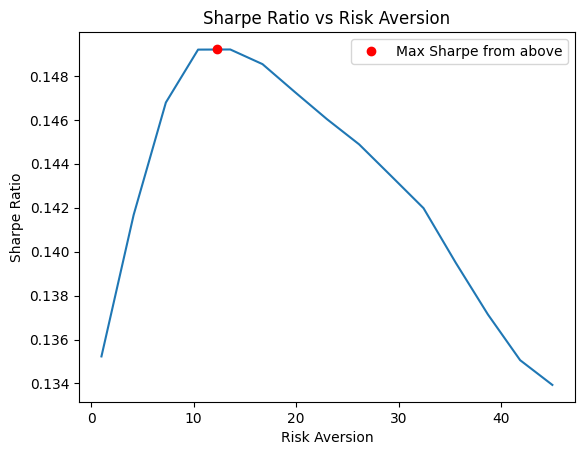

In [63]:
import matplotlib.pyplot as plt

plt.plot(table.index, table["Sharpe"])
plt.plot(table1["Risk Aversion"].iloc[-1], table1["Sharpe"].iloc[-1], 'ro', label='Max Sharpe from above')
plt.xlabel('Risk Aversion')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Risk Aversion')
plt.legend()

In [ ]:
table1["Risk Aversion"].i

iterations
5       9.026093
10     12.138650
15     12.257419
20     12.241571
25     12.242865
50     12.242865
100    12.242865
500    12.242865
Name: Risk Aversion, dtype: float64

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [9]:
# Update the backtest service with a MaxSharpe optimization object
penalties  = [ 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
closest_penalty = None
closest_gap= 100

for i in list(penalties):
    #bs_copy = copy.deepcopy(bs)
    #bs_copy.optimization = 
    bs.optimization = MaxSharpe(
    covariance = Covariance(method='pearson'),
    expected_return = ExpectedReturn(method='geometric'),
    solver_name = 'cvxopt',    # <change this to your preferred solver>
    turnover_penalty= i,   # <change this>
    )

    backtest_trials = Backtest()
    #backtest_trials.run(bs=bs_copy)
    backtest_trials.run(bs=bs)
    
    #annual_turnover = backtest_trials.strategy.turnover(return_series = bs_copy.data.get_return_series()).mean() * 4
    annual_turnover = backtest_trials.strategy.turnover(return_series = bs.data.get_return_series()).mean() * 4
    tolerance = 0.05
    gap = abs(annual_turnover - 1.0)
    if gap < closest_gap:
        if gap < tolerance:
            closest_penalty = i
            break
        else:
            closest_gap = gap
            closest_penalty = i
            new_point1 = i + i/2
            newpoint2 = i - i/2
            if new_point1 not in penalties:
                penalties.extend([new_point1])
            if newpoint2 not in penalties:
                penalties.extend([newpoint2])
    
    print(gap)
    print(closest_gap)
    print(i)

print(closest_penalty)

bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=closest_penalty,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15


KeyboardInterrupt: 

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


/Users/ipacskornel/Downloads/QF_Maters/Second_Term/Quant_Portfolio_Management/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/ipacskornel/Downloads/QF_Maters/Second_Term/Quant_Portfolio_Management/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


The annualized turnover is: Mean-Variance with penalty    1.023971
dtype: float64
Performance metrics for Benchmark
Performance metrics for Mean-Variance


,Benchmark,Mean-Variance
Annual Return,0.056593,0.067126
Cumulative Return,0.701100,0.871993
Annual Volatility,0.145690,0.142641
Sharpe Ratio,0.451148,0.527181
Max Drawdown,-0.263289,-0.371664
Tracking Error,0.000000,0.070138


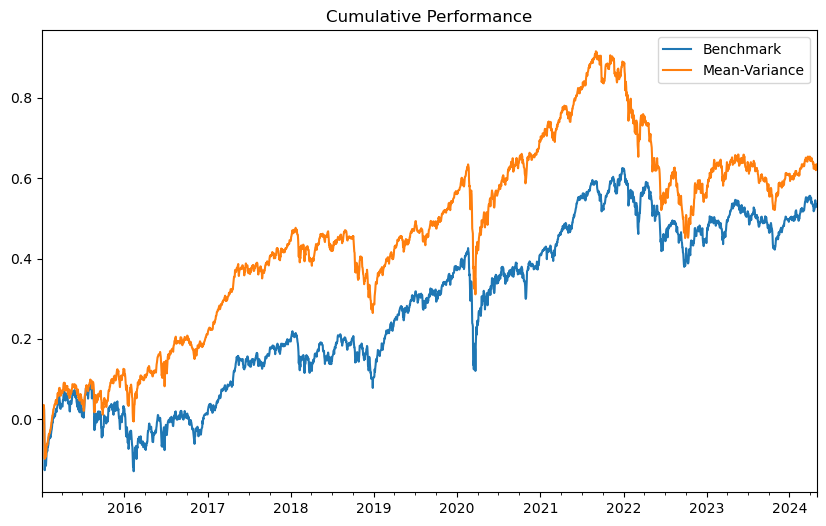

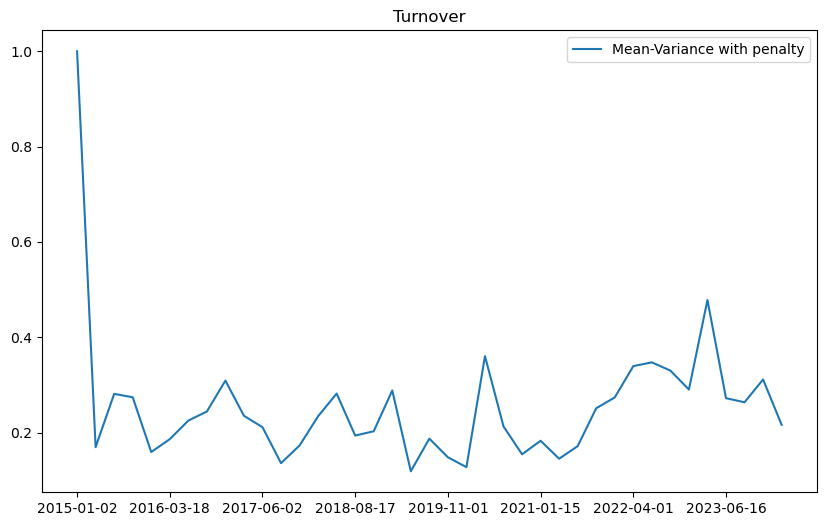

In [ ]:
return_series = bs.data.get_return_series()
sim_mv_gross = bt_ms.strategy.simulate(return_series=return_series , fc=0, vc=0)
sim_mv_net = bt_ms.strategy.simulate(return_series=return_series , fc=0.01, vc=0.003)

sim = pd.concat({
    'bm': bs.data.bm_series,
    'mv': sim_mv_net,
}, axis = 1).dropna()
sim.columns = ['Benchmark', 'Mean-Variance']

# Plot the cumulative performance
np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))

to_mv = bt_ms.strategy.turnover(return_series=return_series)

to = pd.concat({'mv': to_mv}, axis = 1).dropna()
to.columns = ['Mean-Variance with penalty']

to.plot(title='Turnover', figsize = (10, 6))

x = to.mean() * 4
print("The annualized turnover is:", x)

import empyrical as ep 

annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['Benchmark'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
tracking_error = pd.DataFrame(tracking_error, index=['Tracking Error'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd, tracking_error])


